In [1]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.integrate import trapz


# HRV

In [25]:
# Load RR intervals from the file
rr_intervals = pd.read_csv('PCS06_V2_RRIntervals.csv')  # Replace with your file name
rr_intervals = rr_intervals[' rr'].values  # Assuming the column is named 'RR_intervals'

# Calculate SDNN
sdnn = np.std(rr_intervals)

# Calculate RMSSD
differences = np.diff(rr_intervals)
rmssd = np.sqrt(np.mean(differences ** 2))

# Calculate Heart Rate
heart_rate = 60000 / np.mean(rr_intervals)  # Assuming RR intervals are in milliseconds

# Calculate LF and HF
time = np.cumsum(rr_intervals) / 1000.0  # Convert to seconds
fs = 4.0  # Sampling frequency (Hz)
f, psd = welch(rr_intervals, fs=fs, nperseg=1024)
lf_band = (0.04, 0.15)  # Low-frequency band
hf_band = (0.15, 0.4)   # High-frequency band
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
total_power = lf_power + hf_power
lf_percent = (lf_power / total_power) * 100
hf_percent = (hf_power / total_power) * 100
lf_hf_ratio = lf_power / hf_power

print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"Heart Rate: {heart_rate:.2f} bpm")
print(f"LF%: {lf_percent:.2f}%")
print(f"HF%: {hf_percent:.2f}%")
print(f"LF/HF Ratio: {lf_hf_ratio:.2f}")

SDNN: 71.92 ms
RMSSD: 63.49 ms
Heart Rate: 57.03 bpm
LF%: 43.23%
HF%: 56.77%
LF/HF Ratio: 0.76


c:\ProgramData\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 578, using nperseg = 578
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


# CPET

## Anaerobic Threshold

In [ ]:

# Import CPET data for anaerobic threshold analysis
df_cpet = pd.read_csv("PCS16_V2_CPET.csv", header=0)

# Remove any spaces in the names of the columns
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# Display the first few rows
print(df_cpet.head())


# Assuming df_cpet has columns: 'VO2', 'VCO2', 'VE', 'VE/VO2', 'VE/VCO2'
# calculate the first derivative of VE/VO2 and VE/VCO2 to find the inflection points.

# Calculate the derivative of VE/VO2 and VE/VCO2
df_cpet['dVE_VO2'] = np.gradient(df_cpet['VE/VO2'])
df_cpet['dVE_VCO2'] = np.gradient(df_cpet['VE/VCO2'])

# Find peaks in the derivative which correspond to the anaerobic threshold
peaks_VO2 = find_peaks(df_cpet['dVE_VO2'])[0]
peaks_VCO2 = find_peaks(df_cpet['dVE_VCO2'])[0]

# Assuming the anaerobic threshold is at the first peak (can be adjusted based on the data)
at_VO2 = df_cpet['VO2'].iloc[peaks_VO2[0]] if len(peaks_VO2) > 0 else None

print(f"Anaerobic Threshold (VO2): {at_VO2}")


          TIME    VO2/kg          VO2      VCO2           VE     VE/VO2  \
0  0.618000031  5.296448  0.344269127  0.251837  9.038931847  26.255424   
1  1.091500044  8.486753  0.551638901  0.398261  11.02357101  19.983310   
2  1.514000058  8.986061  0.584093988  0.436395  11.62846184  19.908546   
3  2.064333439  9.358850  0.608325303  0.462150  12.32812214  20.265674   
4  2.626000166  9.190443   0.59737879  0.470092  12.44020176  20.824646   

        RER        RER.1        RR        Vt    HR  WorkR  HR.1    VE/VCO2  \
0  0.731512  0.731512249  6.472492  1.396515  84.5    0.0  84.5  35.891983   
1  0.721959  0.721958995  6.335797  1.739887  83.0    0.0  83.0  27.679287   
2  0.747132  0.747132242  7.100592  1.637675  85.0    0.0  85.0  26.646614   
3  0.759709  0.759709001  7.268322  1.696144  85.0    0.0  85.0  26.675573   
4  0.786925  0.786925137  7.121662  1.746812  87.0    0.0  87.0  26.463312   

        FEO2     FECO2  
0  16.638020  3.374905  
1  15.299750  4.364433  
2  15

TypeError: 'value' must be an instance of str or bytes, not a float

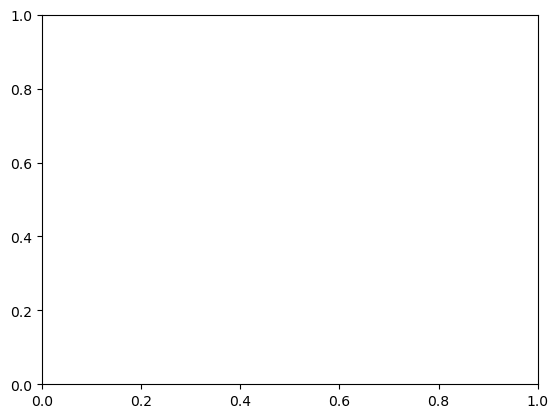

In [14]:
import matplotlib.pyplot as plt
plt.plot(df_cpet['VO2'], df_cpet['VE/VO2'], label='VE/VO2')
plt.plot(df_cpet['VO2'], df_cpet['dVE_VO2'], label='d(VE/VO2)/dt')
plt.axvline(x=at_VO2, color='r', linestyle='--', label='Detected AT')
plt.legend()
plt.xlabel('VO2')
plt.show()

# FMD

In [15]:
# Import the FMD dataset as df_fmd

filename = "PCS04_V2_FMD.csv"

df_fmd2 = pd.read_csv(filename, engine='python')


df_fmd = pd.read_csv(filename, skiprows=7, skipfooter=2, engine='python')

df_fmd.head()

,Time [min:sec],Mean Diameter [mm],Positive Shear Rate [sec-1],Negative Shear Rate [sec-1],Positive Velocity [cm/sec],Negative Velocity [cm/sec],Unnamed: 6,Time [ms],Instant Diameter [mm],Mean Diameter [mm].1,Positive Velocity [cm/sec].1,Negative Velocity [cm/sec].1
0,00:00,4.270,308.9,-61.9,32.97,-6.61,NaN,0,4.273,4.270,32.97,-6.61
1,00:01,4.270,284.2,-68.8,30.34,-7.34,NaN,33,4.271,4.270,32.88,-6.64
2,00:02,4.269,268.7,-68.9,28.67,-7.35,NaN,66,4.278,4.270,32.82,-6.65
3,00:03,4.269,267.8,-70.4,28.58,-7.51,NaN,100,4.279,4.271,32.78,-6.67
4,00:04,4.268,262.1,-70.2,27.96,-7.49,NaN,133,4.275,4.271,32.70,-6.70


In [16]:
# Convert 'Time [min:sec]' to total seconds
df_fmd[['Minutes', 'Seconds']] = df_fmd['Time [min:sec]'].str.split(':', expand=True).astype(float)
df_fmd['Time_seconds'] = df_fmd['Minutes'] * 60 + df_fmd['Seconds']
df_fmd.drop(columns=['Minutes', 'Seconds'], inplace=True)

# Remove rows with missing values in key columns
df_fmd_clean = df_fmd.dropna(subset=['Mean Diameter [mm]', 'Positive Shear Rate [sec-1]', 
                                      'Negative Shear Rate [sec-1]', 'Positive Velocity [cm/sec]', 
                                      'Negative Velocity [cm/sec]'])

# Define baseline and hyperemia periods based on time
baseline_period = df_fmd_clean[df_fmd_clean['Time_seconds'] < 60]  # First 60 sec
hyperemia_period = df_fmd_clean[(df_fmd_clean['Time_seconds'] >= 420) & (df_fmd_clean['Time_seconds'] < 480)]  # 7 to 8 min

# Diameter Baseline
diameter_baseline = baseline_period['Mean Diameter [mm]'].mean() / 10  # Convert mm to cm

# Diameter Maximum
df_fmd['Mean Diameter [mm]'] = pd.to_numeric(df_fmd['Mean Diameter [mm]'], errors='coerce')
diameter_max = hyperemia_period['Mean Diameter [mm]'].max() / 10  # Convert mm to cm

# FMD Percent
fmd_percent = ((diameter_max - diameter_baseline) / diameter_baseline) * 100

# Shear Rate
shear_rate_baseline = df_fmd2['Positive Shear Rate Baseline [sec-1]'][0]
shear_rate_maximum = df_fmd2['Positive Shear Rate Maximum [sec-1]'][0]
shear_rate_areatomaximum = df_fmd2['Positive Shear Rate Area to Maximum []'][0]

# Hyperemia Shear Rate Max AUC
shear_rate_auc = trapz(4 * hyperemia_period['Positive Velocity [cm/sec]'] / hyperemia_period['Mean Diameter [mm]'])

# Mean Velocity
velocity_baseline = df_fmd2['Positive Velocity Baseline [cm/sec]'][0]
velocity_maximum = df_fmd2['Positive Velocity Maximum [cm/sec]'][0]
velocity_mean = df_fmd['Positive Velocity [cm/sec]'].mean()

# Flow Rate
flow_rate = (3.1416 * ((df_fmd['Mean Diameter [mm]'] / 10) / 2) ** 2 * df_fmd['Positive Velocity [cm/sec]'] * 60).mean()

# FMD Normalized
fmd_normalized = fmd_percent / shear_rate_auc

print(f"Diameter Baseline (cm): {diameter_baseline:.3f}")
print(f"Diameter Maximum (cm): {diameter_max:.3f}")
print(f"FMD (%): {fmd_percent:.2f}")
print(f"Shear Rate Baseline (s⁻¹): {shear_rate_baseline:.2f}")
print(f"Shear Rate Maximum (s⁻¹): {shear_rate_maximum:.2f}")
print(f"Shear Rate Area to Maximum (s⁻¹): {shear_rate_areatomaximum:.2f}")
print(f"Hyperemia Shear Rate Max (AUC): {shear_rate_auc:.2f}")
print(f"Baseline Velocity (cm/s): {velocity_baseline:.2f}")
print(f"Maximum Velocity (cm/s): {velocity_maximum:.2f}")
print(f"Mean Velocity (cm/s): {velocity_mean:.2f}")
print(f"Flow Rate (ml/min): {flow_rate:.2f}")
print(f"FMD Normalized: {fmd_normalized:.5f}")


Diameter Baseline (cm): 0.427
Diameter Maximum (cm): 0.475
FMD (%): 11.32
Shear Rate Baseline (s⁻¹): 325.15
Shear Rate Maximum (s⁻¹): 894.22
Shear Rate Area to Maximum (s⁻¹): 19562.50
Hyperemia Shear Rate Max (AUC): 2197.76
Baseline Velocity (cm/s): 34.70
Maximum Velocity (cm/s): 97.44
Mean Velocity (cm/s): 29.97
Flow Rate (ml/min): 282.98
FMD Normalized: 0.00515


C:\Users\ZCooper\AppData\Local\Temp\ipykernel_37476\1023748718.py:31: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  shear_rate_auc = trapz(4 * hyperemia_period['Positive Velocity [cm/sec]'] / hyperemia_period['Mean Diameter [mm]'])


[]
